In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
mostrecent=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
mostrecent[0]

'2017-08-23'

In [11]:
# Calculate the date one year from the last date in data set.
#year_ago = mostrecent - dt.timedelta(days=365)
queryenddate = dt.date(2017, 8, 23) - dt.timedelta(365)
queryenddate

datetime.date(2016, 8, 23)

In [12]:
# Perform a query to retrieve the data and precipitation scores

thisquery=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=queryenddate).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame(thisquery).set_index("date")
precipgroup=precipitation_df.groupby("date").max()
prec_df=pd.DataFrame(precipgroup)
prec_df.head(30)

,prcp
date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
2016-08-28,2.07
2016-08-29,0.90
2016-08-30,0.05
2016-08-31,2.46


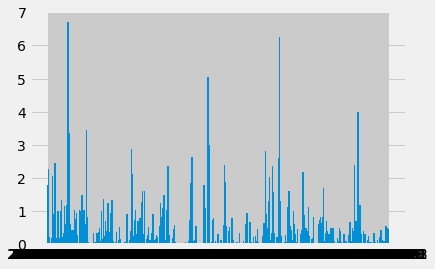

<Figure size 720x216 with 0 Axes>

In [14]:
# Sort the dataframe by date
prec_df=prec_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(prec_df.index, prec_df["prcp"], width=1.5)
plt.figure(figsize=(10, 3))
plt.tight_layout()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summarydict = {
    "Average Rainfall": [prec_df["prcp"].mean()],
    "Max Rainfall": [prec_df["prcp"].max()],
    "Min Rainfall": [prec_df["prcp"].min()],
    "Number of Measurements": [prec_df["prcp"].count()]
}
summary_df = pd.DataFrame.from_dict(summarydict)
summary_df

,Average Rainfall,Max Rainfall,Min Rainfall,Number of Measurements
0,0.520765,6.7,0.0,366


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
stationquery=session.query(Station.name).group_by(Station.name).count()
stationquery

9

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order
session.query(Measurement.station, func.count(Measurement.prcp)).group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#As seen above, this is USC00519281
tempmin=session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()[0][0]
print(f"The highest temperature is {tempmin}")
tempmax=session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()[0][0]
print(f"The highest temperature is {tempmax}")
tempavg=session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()[0][0]
print(f"The average temperature is {tempavg}")

The highest temperature is 54.0
The highest temperature is 85.0
The average temperature is 71.66378066378067


Text(0.5, 0, 'Temperature')

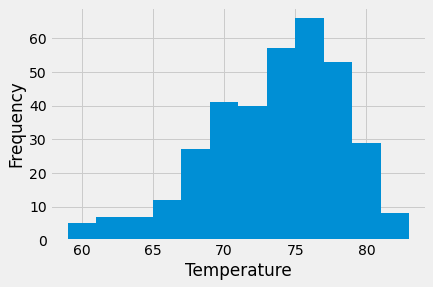

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempmeasures=session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date>=queryenddate).all()
tempmeasures = [r[0] for r in tempmeasures]
plt.hist(tempmeasures, bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')


# Close session

In [20]:
# Close Session
session.close()